<a href="https://colab.research.google.com/github/Kruglikle/Analysis-of-school-textbooks/blob/main/rezeptivnay_leksika.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Учебник Spotlight**

Подготовка датасета с лексикой.
1. Извлечь лексику из Word-документа (.docx)
Мы получим два списка:

active_words — из блоков Активная:

passive_words — из блоков Пассивная: (они пойдут в рецептивный словарь)

2. Сохранение в csv. Формат:

| Тип       | Слово    |
| --------- | -------- |
| Пассивная | ant      |
| Пассивная | bed      |
| Активная  | Hello!   |
| Активная  | Goodbye! |

3. Позже используем этот CSV для анализа учебника с лемматизацией через spaCy (только без времён и степеней сравнения!).



In [ ]:
!pip install python-docx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 6.6 MB/s eta 0:00:00


In [ ]:
from docx import Document
import csv
import re

#Путь к файлу Word
DOCX_PATH = "/content/Рецептивная лексика спотлайт.docx"
OUTPUT_CSV = "/content/spotlight_rezeptivnay.csv"

# Функция разбивает строку на отдельные слова (с запятыми и переносами строк)
def extract_words(text):
    text = text.replace('\n', ' ')
    words = re.split(r'[,\s]+', text)
    return [w.strip() for w in words if w.strip()]

# Парсим документ
def parse_docx_vocab(docx_path):
    doc = Document(docx_path)
    current_type = None
    all_entries = []

    for para in doc.paragraphs:
        text = para.text.strip()
        if not text:
            continue
        if text.startswith("Активная"):
            current_type = "Активная"
            continue
        elif text.startswith("Пассивная"):
            current_type = "Пассивная"
            continue
        elif current_type:
            words = extract_words(text)
            for word in words:
                all_entries.append((current_type, word.lower()))

    return all_entries

# Сохраняем в CSV
def save_vocab_to_csv(entries, output_csv):
    with open(output_csv, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Тип', 'Слово'])
        writer.writerows(entries)

# Запуск
entries = parse_docx_vocab(DOCX_PATH)
save_vocab_to_csv(entries, OUTPUT_CSV)

print(f"Готово! Извлечено {len(entries)} слов.")


Готово! Извлечено 716 слов.


Код для активной и рецептивной вместе:

In [ ]:
from docx import Document
import csv
import re

# Пути к файлам
DOCX_PATH = "/content/Рецептивная лексика спотлайт.docx"
OUTPUT_CSV = "/content/spotlight_rezept_only.csv"

# Функция для нормализации заголовков
def fix_label(text):
    text = text.lower()
    if "пасс" in text:
        return "Пассивная"
    elif "актив" in text:
        return "Активная"

    return None

# Основной парсинг документа
def extract_phrases(docx_path):
    doc = Document(docx_path)
    entries = []
    current_type = None
    current_block = ""

    for para in doc.paragraphs:
        text = para.text.strip()
        if not text:
            continue

        label = fix_label(text)
        if label:
            # Сохраняем предыдущий блок
            if current_block:
                entries.extend(split_block(current_type, current_block))
                current_block = ""
            current_type = label
        elif current_type:
            current_block += " " + text

    if current_block:
        entries.extend(split_block(current_type, current_block))

    return entries

# Разделение блока на фразы
def split_block(label, block):
    block = block.strip()

    # если это просто список слов через запятую — разбиваем
    if re.match(r'^([a-zA-Zа-яА-ЯёЁ0-9 \-,]+)$', block):
        parts = [p.strip() for p in block.split(',') if p.strip()]
        return [(label, p) for p in parts]

    # если есть фразы — разделяем по ?!., но не разбиваем по запятым
    parts = re.split(r'(?<=[.?!])\s+', block)
    return [(label, p.strip()) for p in parts if p.strip()]

# Сохраняем в CSV
def save_to_csv(entries, path):
    with open(path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Тип', 'Фраза'])
        writer.writerows(entries)

# Запуск
entries = extract_phrases(DOCX_PATH)
save_to_csv(entries, OUTPUT_CSV)

print(f"Готово! Извлечено {len(entries)} фраз. CSV сохранён в {OUTPUT_CSV}")


Готово! Извлечено 149 фраз. CSV сохранён в /content/spotlight_rezept_only.csv


Код только для рецептивной лексики:

In [ ]:
from docx import Document
import csv
import re

# Пути к файлам
DOCX_PATH = "/content/Только рецептив.docx"
OUTPUT_CSV = "/content/spotlight_rezept_only7.csv"

# Слова, которые нужно исключить
excluded_words = {"nanny shine", "lulu", "larry", "chuckles", "yes"}

# Функция для нормализации заголовков
def fix_label(text):
    text = text.lower()
    if "пасс" in text:
        return "Пассивная"
    elif "актив" in text:
        return "Активная"
    return None

# Основной парсинг документа
def extract_phrases(docx_path):
    doc = Document(docx_path)
    entries = []
    current_type = None
    current_block = ""

    for para in doc.paragraphs:
        text = para.text.strip()
        if not text:
            continue

        label = fix_label(text)
        if label:
            # Сохраняем только пассивные блоки
            if current_block and current_type == "Пассивная":
                entries.extend(split_block(current_type, current_block))
            current_type = label
            current_block = ""
        elif current_type:
            current_block += " " + text

    # Обработка последнего блока
    if current_block and current_type == "Пассивная":
        entries.extend(split_block(current_type, current_block))

    return entries

# Разделение блока на фразы
def split_block(label, block):
    block = block.strip()

    # Шаг 1: заменим окончания предложений спец-разделителем
    block = re.sub(r'(?<=[.!?…;])\s*', '|', block)

    # Шаг 2: запятая + заглавная буква → разделитель
    block = re.sub(r',\s+(?=[A-ZА-Я])', '|', block)

    # Шаг 3: остальные запятые → разделители
    block = re.sub(r',\s*', '|', block)

    # Шаг 4: разбиваем по | и очищаем
    parts = [p.strip() for p in block.split('|') if p.strip()]

    # Шаг 5: фильтруем исключённые фразы
    clean_parts = [
        (label, p) for p in parts
        if p.lower() not in excluded_words
    ]

    return clean_parts

# Сохраняем в CSV
def save_to_csv(entries, path):
    with open(path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Тип', 'Фраза'])
        writer.writerows(entries)

# Запуск
entries = extract_phrases(DOCX_PATH)
save_to_csv(entries, OUTPUT_CSV)

print(f"Готово! Извлечено {len(entries)} пассивных фраз (без исключений). CSV: {OUTPUT_CSV}")


Готово! Извлечено 240 пассивных фраз (без исключений). CSV: /content/spotlight_rezept_only7.csv


**Этап работы с учебником**

1. Загружаем CSV с активной/пассивной лексикой.

2. Загружаем учебник .txt, где страницы размечены как === Страница 12 ===.

3. Лемматизируем текст и слова (с помощью spaCy).

4. Ищем вхождения каждого слова (с учётом лемм).

5. Сохраняем результат в новый CSV:
с колонками Слово, Тип, Кол-во вхождений, Страницы.





In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 125.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import csv
import re
import spacy
import pandas as pd

# Загрузка модели spaCy
nlp = spacy.load("en_core_web_sm")

# Пути к файлам
CSV_PATH = "/content/spotlight_rezept_only7.csv"   # файл с фразами
TXT_PATH = "/content/spotlight2.txt"                   # учебник с разметкой === Страница N ===
OUTPUT_PATH = "/content/spotlight_vocab_result7.csv"   # выходной CSV

# Загрузка фраз из CSV
def load_vocab_from_csv(csv_path):
    entries = []
    with open(csv_path, newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            phrase = row['Фраза'].strip()
            word_type = row['Тип'].strip()
            if phrase:
                entries.append((word_type, phrase))
    return entries

# Загрузка текста учебника по страницам
def load_textbook(txt_path):
    with open(txt_path, 'r', encoding='utf-8') as f:
        text = f.read()
    pages = re.split(r'=== Страница (\d+) ===', text)
    page_dict = {}
    for i in range(1, len(pages), 2):
        page_number = int(pages[i])
        content = pages[i+1].lower()
        page_dict[page_number] = content
    return page_dict

# Лемматизация фразы без удаления стоп-слов (чтобы сохранить фразу как единицу)
def normalize_exact_phrase(phrase):
    doc = nlp(phrase.lower())
    tokens = [token.lemma_.lower().strip() for token in doc if token.is_alpha or token.text in {"'", "-"}]
    return ' '.join(tokens)

# Лемматизация страницы (тоже без удаления стоп-слов)
def lemmatize_page_exact(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower().strip() for token in doc if token.is_alpha or token.text in {"'", "-"}]
    return ' '.join(tokens)

# Поиск точных фраз
def analyze_phrases_exact(vocab_entries, pages):
    results = []

    # Предобработка фраз
    norm_map = {
        normalize_exact_phrase(phrase): (word_type, phrase)
        for word_type, phrase in vocab_entries
    }

    # Кэш: лемматизированные страницы
    lemmatized_pages = {
        page_num: lemmatize_page_exact(content)
        for page_num, content in pages.items()
    }

    # Поиск
    for norm_phrase, (word_type, original_phrase) in norm_map.items():
        if not norm_phrase:
            continue

        total_count = 0
        matched_pages = set()

        for page_num, lemmatized_text in lemmatized_pages.items():
            # Точное вхождение фразы как последовательности лемм
            count = len(re.findall(r'\b' + re.escape(norm_phrase) + r'\b', lemmatized_text))
            if count > 0:
                total_count += count
                matched_pages.add(page_num)

        if total_count > 0:
            results.append({
                'Фраза': original_phrase,
                'Тип': word_type,
                'Кол-во повторений': total_count,
                'Страницы': ', '.join(map(str, sorted(matched_pages)))
            })

    return results

# Сохраняем результаты в CSV
def save_results(results, output_path):
    df = pd.DataFrame(results)
    df.sort_values(by='Кол-во повторений', ascending=False, inplace=True)
    df.to_csv(output_path, index=False, encoding='utf-8-sig')

# === Запуск ===
vocab_entries = load_vocab_from_csv(CSV_PATH)
pages = load_textbook(TXT_PATH)
results = analyze_phrases_exact(vocab_entries, pages)
save_results(results, OUTPUT_PATH)

print(f"Готово! Найдено фраз с вхождениями: {len(results)}")


Готово! Найдено фраз с вхождениями: 19


**Визуализация. Гистограмма частотности пассивной лексики**

БАГИ:

1. удалить stop-words

Загрузите файл spotlight_vocab_result.csv


Saving spotlight_vocab_result6.csv to spotlight_vocab_result6 (1).csv


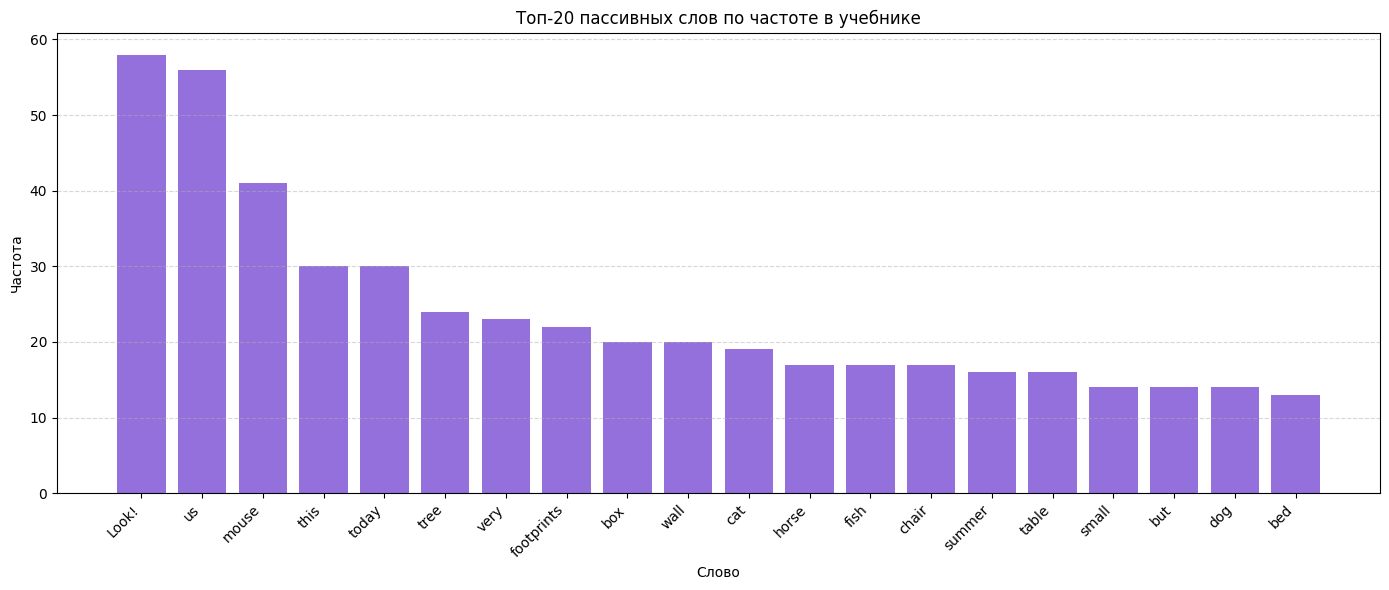

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Загрузите готовый CSV с результатами анализа
print("Загрузите файл spotlight_vocab_result.csv")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Читаем CSV
df = pd.read_csv(filename)

# Фильтруем только пассивную лексику
passive_df = df[df['Тип'].str.lower() == 'пассивная']

# Выбираем топ-N по частотности
TOP_N = 20
top_passive = passive_df.sort_values(by='Кол-во повторений', ascending=False).head(TOP_N)

# Строим вертикальную гистограмму
plt.figure(figsize=(14, 6))
plt.bar(top_passive['Фраза'], top_passive['Кол-во повторений'], color='mediumpurple')
plt.xlabel('Слово')
plt.ylabel('Частота')
plt.title(f'Топ-{TOP_N} пассивных слов по частоте в учебнике')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
!pip install plotly


In [ ]:
import pandas as pd
import plotly.graph_objects as go
from google.colab import files

# Загрузите CSV с результатами
print("Загрузите файл spotlight_vocab_result.csv")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Чтение
df = pd.read_csv(filename)

# Отдельно фильтруем активную и пассивную
active_df = df[df['Тип'].str.lower() == 'активная'].sort_values(by='Кол-во вхождений', ascending=False).head(15)
passive_df = df[df['Тип'].str.lower() == 'пассивная'].sort_values(by='Кол-во вхождений', ascending=False).head(15)

# Создаём интерактивный график
fig = go.Figure()

fig.add_trace(go.Bar(
    x=active_df['Фраза'],
    y=active_df['Кол-во вхождений'],
    name='Активная лексика',
    marker_color='indianred'
))

fig.add_trace(go.Bar(
    x=passive_df['Фраза'],
    y=passive_df['Кол-во вхождений'],
    name='Пассивная лексика',
    marker_color='mediumseagreen'
))

fig.update_layout(
    title='Сравнение частотности активной и пассивной лексики',
    xaxis_title='Слова',
    yaxis_title='Частота',
    barmode='group',
    xaxis_tickangle=-45,
    template='plotly_white',
    width=1000,
    height=500
)

fig.show()


Загрузите файл spotlight_vocab_result.csv


Saving spotlight_vocab_result4.csv to spotlight_vocab_result4 (4).csv


**Пересечения в Spotlight**

In [ ]:
from docx import Document
import pandas as pd
import re

Контекстный учет

In [ ]:
from docx import Document
import pandas as pd
import re
from collections import defaultdict

def normalize_phrase(phrase):
    phrase = phrase.lower().strip()
    phrase = re.sub(r"^(the|a|an)\s+", "", phrase)
    phrase = re.sub(r"[.,!?;:]$", "", phrase)
    phrase = re.sub(r"\s+", " ", phrase)
    return phrase

# 1. Загрузка и обработка файла
doc = Document("Рецептивная лексика спотлайт.docx")

data = []
current_status = None
block_number = 0

for para in doc.paragraphs:
    text = para.text.strip()
    if not text:
        continue

    lowered = text.lower()

    if "активная" in lowered:
        current_status = "active"
        block_number += 1
        continue
    elif "пассивная" in lowered:
        current_status = "passive"
        block_number += 1
        continue

    if current_status:
        # разбиваем на фразы по запятым и переносам строк
        chunks = re.split(r"[,\n]+", text)
        for phrase in chunks:
            cleaned = normalize_phrase(phrase)
            if cleaned:
                data.append((cleaned, current_status, block_number))

df = pd.DataFrame(data, columns=["phrase", "status", "block"])
df = df.drop_duplicates()

# 2. Собираем контексты для каждого слова
word_context = defaultdict(lambda: {"passive": set(), "active": set()})

for _, row in df.iterrows():
    phrase = row["phrase"]
    status = row["status"]
    words = phrase.split()

    for w in words:
        word_context[w][status].add(phrase)

# 3. Определяем слова, которые есть и в пассивной, и в активной лексике
words_passive_active = [w for w, ctx in word_context.items() if ctx["passive"] and ctx["active"]]

# 4. Формируем отчёт по ключевым словам
report = []

for w in words_passive_active:
    passive_phrases = sorted(word_context[w]["passive"])
    active_phrases = sorted(word_context[w]["active"])
    report.append({
        "word": w,
        "passive_context_count": len(passive_phrases),
        "active_context_count": len(active_phrases),
        "passive_contexts": "; ".join(passive_phrases),
        "active_contexts": "; ".join(active_phrases),
    })

report_df = pd.DataFrame(report).sort_values(by="word")

# 5. Сохраняем отчёт в CSV
report_df.to_csv("word_contexts_passive_active_report.csv", index=False)

print(f"Найдено {len(report_df)} слов, которые встречаются и в пассивной, и в активной лексике.")
print(report_df.head(10))


Найдено 47 слов, которые встречаются и в пассивной, и в активной лексике.
         word  passive_context_count  active_context_count  \
15        and                      5                     1   
38       bear                      1                     1   
41        big                      1                     1   
7         box                      3                     2   
30       cake                      1                     1   
28    candles                      2                     1   
31  chocolate                      1                     1   
18     colour                      2                     1   
24    country                      1                     1   
6         dow                      1                     1   

                                     passive_contexts      active_contexts  
15  grandma and; it's raining cats and; let's sing...       fish and chips  
38                               about the teddy bear           teddy bear  
41          

Учитываются:
пассивные контексты (фразы),

активные контексты,

количество пассивных и активных контекстов,

блоки, в которых встречается слово в пассивной и активной лексике,

минимальную разницу блоков — через сколько блоков слово "активируется".



In [ ]:
from docx import Document
import pandas as pd
import re
from collections import defaultdict

def normalize_phrase(phrase):
    phrase = phrase.lower().strip()
    phrase = re.sub(r"^(the|a|an)\s+", "", phrase)
    phrase = re.sub(r"[.,!?;:]$", "", phrase)
    phrase = re.sub(r"\s+", " ", phrase)
    return phrase

# 1. Загружаем и обрабатываем файл
doc = Document("Рецептивная лексика спотлайт.docx")

data = []
current_status = None
block_number = 0

for para in doc.paragraphs:
    text = para.text.strip()
    if not text:
        continue
    lowered = text.lower()

    if "активная" in lowered:
        current_status = "active"
        block_number += 1
        continue
    elif "пассивная" in lowered:
        current_status = "passive"
        block_number += 1
        continue

    if current_status:
        chunks = re.split(r"[,\n]+", text)
        for phrase in chunks:
            cleaned = normalize_phrase(phrase)
            if cleaned:
                data.append((cleaned, current_status, block_number))

df = pd.DataFrame(data, columns=["phrase", "status", "block"])
df = df.drop_duplicates()

# 2. Анализ по фразам: ищем переходы пассивных фраз в активные с блоками и разницей
passive_df = df[df["status"] == "passive"]
active_df = df[df["status"] == "active"]

merged = pd.merge(passive_df, active_df, on="phrase", suffixes=("_passive", "_active"))
merged["block_diff"] = merged["block_active"] - merged["block_passive"]

merged = merged.sort_values("block_diff")

# 3. Анализ по словам: контексты и блоки

word_context = defaultdict(lambda: {"passive": set(), "active": set()})
word_block_passive = defaultdict(set)
word_block_active = defaultdict(set)

for _, row in df.iterrows():
    phrase = row["phrase"]
    status = row["status"]
    block = row["block"]
    words = phrase.split()

    for w in words:
        word_context[w][status].add(phrase)
        if status == "passive":
            word_block_passive[w].add(block)
        else:
            word_block_active[w].add(block)

# 4. Собираем отчёт для слов, которые есть и в пассивной, и в активной лексике
words_passive_active = [w for w in word_context if word_context[w]["passive"] and word_context[w]["active"]]

report_words = []
for w in words_passive_active:
    passive_phrases = sorted(word_context[w]["passive"])
    active_phrases = sorted(word_context[w]["active"])
    passive_blocks = sorted(word_block_passive[w])
    active_blocks = sorted(word_block_active[w])
    report_words.append({
        "word": w,
        "passive_context_count": len(passive_phrases),
        "active_context_count": len(active_phrases),
        "passive_contexts": "; ".join(passive_phrases),
        "active_contexts": "; ".join(active_phrases),
        "passive_blocks": ", ".join(map(str, passive_blocks)),
        "active_blocks": ", ".join(map(str, active_blocks)),
        "min_block_diff": min([a - p for p in passive_blocks for a in active_blocks if a - p >= 0], default=None)
    })

report_words_df = pd.DataFrame(report_words).sort_values("word")

# 5. Сохраняем результаты
merged.to_csv("phrases_passive_to_active_with_blocks.csv", index=False)
report_words_df.to_csv("words_contexts_and_blocks_report.csv", index=False)

print(f"Фраз, перешедших из пассивных в активные: {len(merged)}")
print(merged.head(10))

print(f"Слов, встречающихся и в пассивной, и в активной лексике: {len(report_words_df)}")
print(report_words_df.head(10))


Фраз, перешедших из пассивных в активные: 15
       phrase status_passive  block_passive status_active  block_active  \
9       house        passive             19        active            17   
7       house        passive             16        active            17   
13  chocolate        passive             32        active            35   
5       house        passive             14        active            17   
10      house        passive             19        active            24   
14     summer        passive             71        active            76   
8       house        passive             16        active            24   
6       house        passive             14        active            24   
3         dow        passive              6        active            20   
2         win        passive              6        active            20   

    block_diff  
9           -2  
7            1  
13           3  
5            3  
10           5  
14           5  
8         

График распределения разницы блоков (block_diff) для фраз
Через сколько блоков слова/фразы переходят из пассивных в активные.



Как высчитывается разница?

Разница - минимальное положительное значение block_active - block_passive.


56 - 6 = 50

56 - 23 = 33

56 - 62 = -6 (отрицательное — игнорируем, активный блок раньше пассивного)

63 - 6 = 57

63 - 23 = 40

63 - 62 = 1

Минимальная положительная разница — 1 (63 - 62).

/tmp/ipython-input-21-3125957029.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_fast_words, x='min_block_diff', y='word', palette='coolwarm')


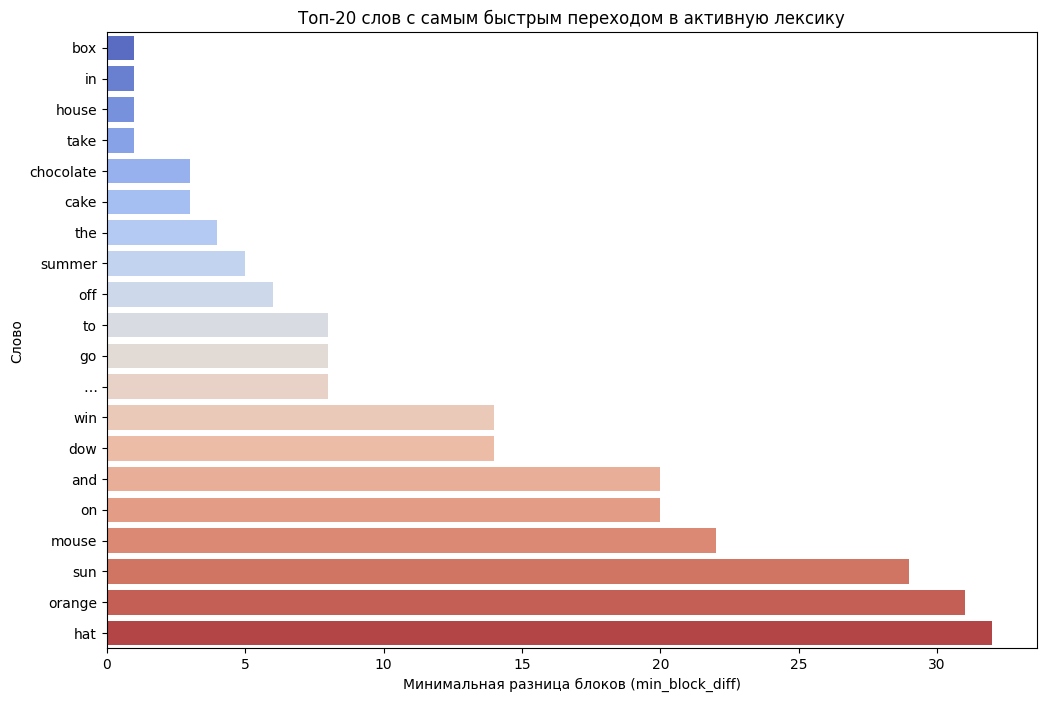

In [ ]:
top_fast_words = df_filtered.sort_values('min_block_diff').head(20)

plt.figure(figsize=(12,8))
sns.barplot(data=top_fast_words, x='min_block_diff', y='word', palette='coolwarm')
plt.title('Топ-20 слов с самым быстрым переходом в активную лексику')
plt.xlabel('Минимальная разница блоков')
plt.ylabel('Слово')
plt.show()


Количество пассивных и активных контекстов для слов
Можно построить столбчатую диаграмму для первых N слов.

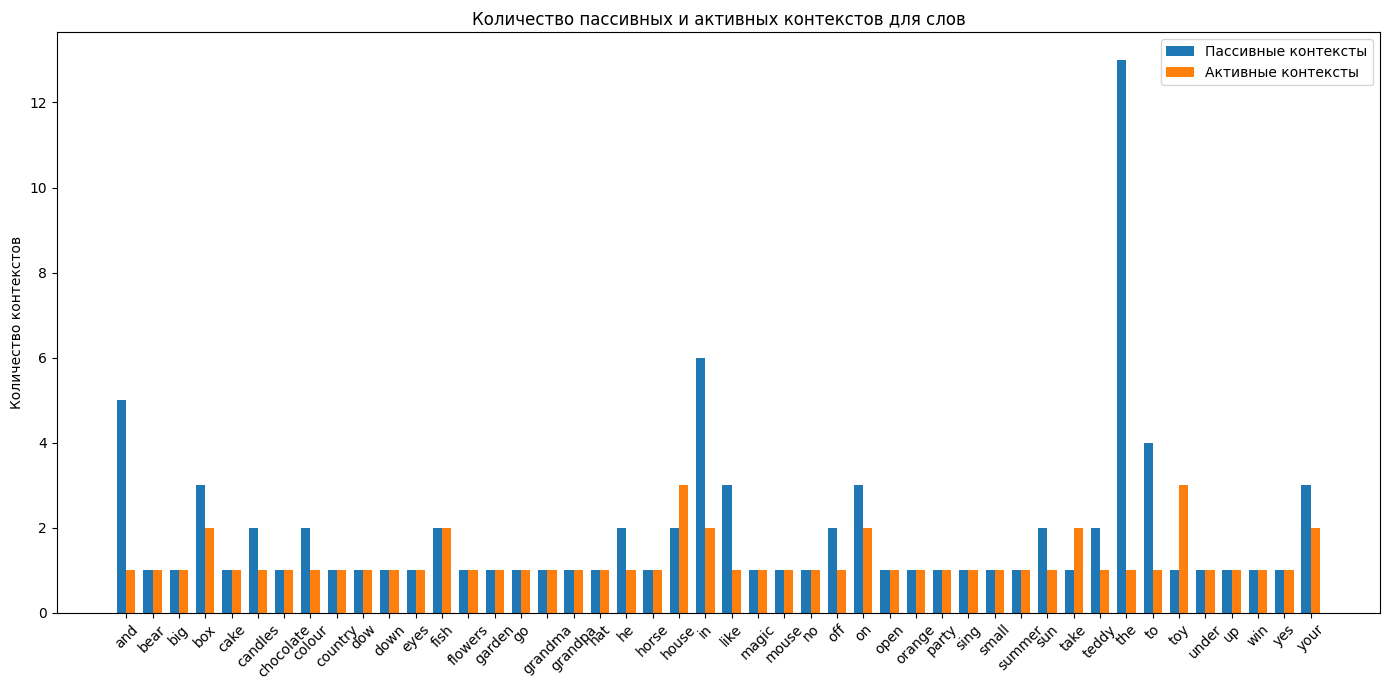

In [ ]:
top_words = report_words_df.head(46)

x = range(len(top_words))
width = 0.35

plt.figure(figsize=(14,7))
plt.bar(x, top_words['passive_context_count'], width=width, label='Пассивные контексты')
plt.bar([i + width for i in x], top_words['active_context_count'], width=width, label='Активные контексты')

plt.xticks([i + width/2 for i in x], top_words['word'], rotation=45)
plt.ylabel('Количество контекстов')
plt.title('Количество пассивных и активных контекстов для слов')
plt.legend()
plt.tight_layout()
plt.show()


Про каждое слово в отдельности

In [ ]:
word = 'house'  # пример
row = df[df['word'] == word]
if not row.empty:
    print(f"Слово: {word}")
    print("Пассивные контексты:")
    print(row.iloc[0]['passive_contexts'])
    print("\nАктивные контексты:")
    print(row.iloc[0]['active_contexts'])
    print(f"\nПассивные блоки: {row.iloc[0]['passive_blocks']}")
    print(f"Активные блоки: {row.iloc[0]['active_blocks']}")
    print(f"Минимальная разница блоков: {row.iloc[0]['min_block_diff']}")
else:
    print(f"Слово {word} не найдено в таблице.")

Слово: house
Пассивные контексты:
house; my house

Активные контексты:
country house; green house; house

Пассивные блоки: 14, 16, 19, 27
Активные блоки: 17, 24
Минимальная разница блоков: 1.0


Визуализация каждого слова в отдельности

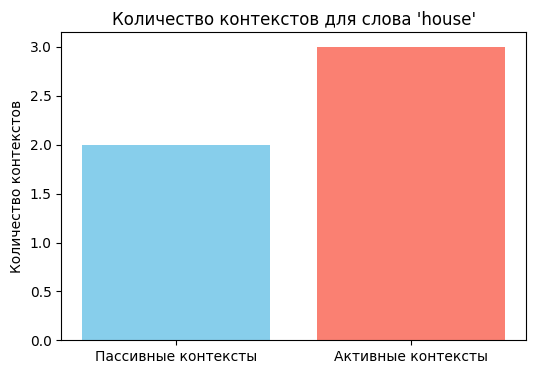

In [ ]:
import matplotlib.pyplot as plt

word = 'house'  # можно заменить на любое другое слово
row = df[df['word'] == word]

if not row.empty:
    passive_contexts = row.iloc[0]['passive_contexts'].split('; ')
    active_contexts = row.iloc[0]['active_contexts'].split('; ')

    counts = [len(passive_contexts), len(active_contexts)]
    labels = ['Пассивные контексты', 'Активные контексты']

    plt.figure(figsize=(6,4))
    plt.bar(labels, counts, color=['skyblue', 'salmon'])
    plt.title(f"Количество контекстов для слова '{word}'")
    plt.ylabel('Количество контекстов')
    plt.show()
else:
    print(f"Слово {word} не найдено в таблице.")


**Код для Кузрвлева . Готовый датасет /kuzovlev_leksika_rezeptivnaya**

---



**Подготовка датасета с лексикой, предварительная очистка, лемматизация, регистр**

Используем spaCy, чтобы корректно лемматизировать:

существительные (stepsisters → stepsister),

глаголы (went → go),

прилагательные (better → good),

устойчивые фразы (a stepsister, have been, got up и т. д.).

Лемматизация обеих сторон нужна, чтобы исключить несрабатывание при разных формах слова (множественное число, прошедшее время, степени сравнения и т. д.). -- лемматизируем и учебник, и csv

In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Загружает CSV-файл с рецептивной лексикой.

Загружает txt-файл учебника Кузовлева.

Делит учебник по страницам (=== Страница N ===).

Ищет, какие слова из CSV встречаются на каких страницах, сколько их всего.

Сохраняет результат в CSV-таблицу вида:


| Слово        | Кол-во вхождений | Страницы   |
| ------------ | ---------------- | ---------- |
| apple        | 5                | 11, 14, 15 |
| good morning | 1                | 10         |


In [ ]:
import csv
import re
import spacy
from collections import defaultdict
import pandas as pd

# Инициализируем spaCy
nlp = spacy.load("en_core_web_sm")

# Пути к файлам
CSV_PATH = r"/content/kuzovlev_leksika_rezeptivnaya - kuzovlev_phrases3.csv.csv"
TXT_PATH = r"/content/kuzovlev2_2class.txt"
OUTPUT_PATH = r"/content/kuzovlev2_2class.csv"

# 1. Загрузка лексики из CSV
def load_vocab(csv_path):
    with open(csv_path, newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        vocab = set()
        for row in reader:
            for item in row:
                word = item.strip().lower()
                if word:
                    vocab.add(word)
    return vocab

# 2. Загрузка учебника и разбиение по страницам
def load_textbook(txt_path):
    with open(txt_path, 'r', encoding='utf-8') as f:
        text = f.read()

    pages = re.split(r'=== Страница (\d+) ===', text)
    page_dict = {}
    for i in range(1, len(pages), 2):
        page_number = int(pages[i])
        content = pages[i+1].lower()
        page_dict[page_number] = content
    return page_dict

# 3. Лемматизация фраз (из словаря)
def normalize_phrase_spacy(phrase):
    doc = nlp(phrase.lower())
    words = [token.lemma_ for token in doc if token.text.lower() not in {'a', 'an', 'the'}]
    return ' '.join(words)

# 4. Поиск с учётом лемм
def analyze_vocab_spacy(vocab, pages):
    word_data = []

    # Предварительно нормализуем словарь
    norm_vocab_map = {
        normalize_phrase_spacy(w): w for w in vocab
    }

    for norm_phrase, original_word in norm_vocab_map.items():
        total_count = 0
        page_matches = set()

        for page_num, content in pages.items():
            doc = nlp(content)
            lemmatized_text = ' '.join([token.lemma_.lower() for token in doc])

            if norm_phrase in lemmatized_text:
                count = lemmatized_text.count(norm_phrase)
                total_count += count
                page_matches.add(page_num)

        if total_count > 0:
            word_data.append({
                'Слово': original_word,
                'Кол-во вхождений': total_count,
                'Страницы': ', '.join(map(str, sorted(page_matches)))
            })

    return word_data

# 5. Сохранение CSV
def save_to_csv(word_data, output_path):
    df = pd.DataFrame(word_data)
    df.sort_values(by='Кол-во вхождений', ascending=False, inplace=True)
    df.to_csv(output_path, index=False, encoding='utf-8-sig')

# Запуск
vocab = load_vocab(CSV_PATH)
pages = load_textbook(TXT_PATH)
word_data = analyze_vocab_spacy(vocab, pages)
save_to_csv(word_data, OUTPUT_PATH)

print(f"Готово! Найдено {len(word_data)} слов с вхождениями.")


Готово! Найдено 14 слов с вхождениями.


Визуализация

Загрузите файл vocab_in_textbook.csv


Saving kuzovlev_all.csv to kuzovlev_all (2).csv


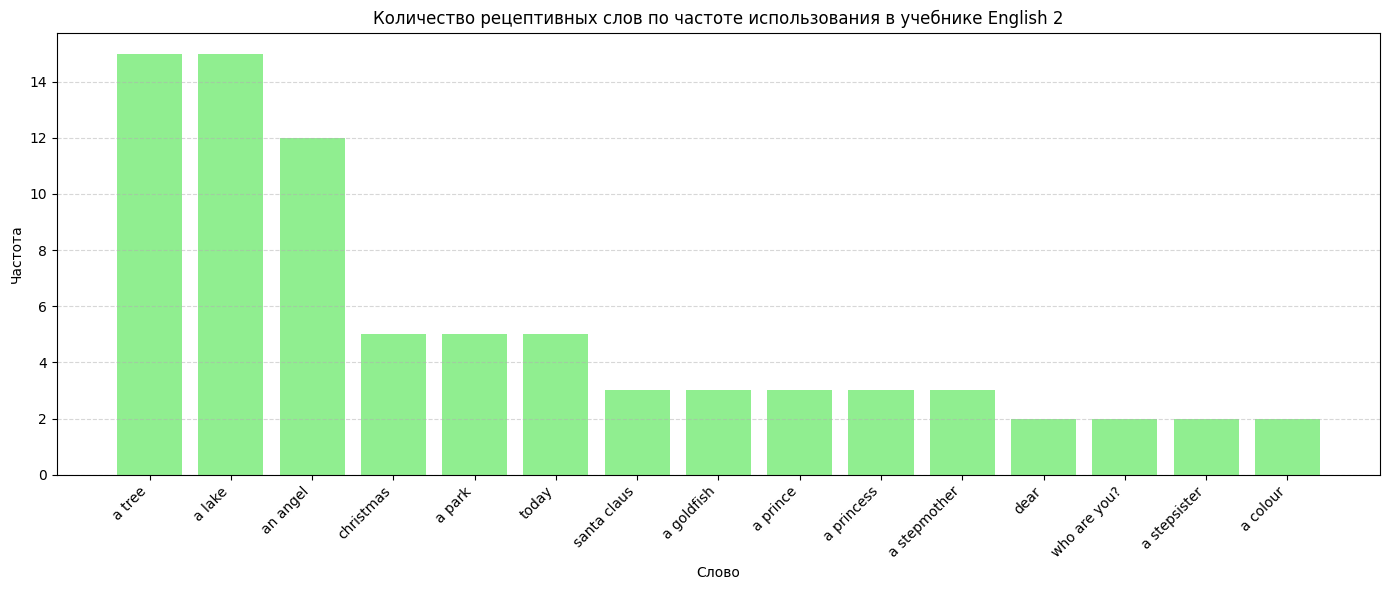

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Загрузка CSV
print("Загрузите файл vocab_in_textbook.csv")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Чтение CSV в DataFrame
df = pd.read_csv(filename)

# Сортировка и выбор топ-N слов
TOP_N = 20  # можно менять
top_words = df.sort_values(by='Кол-во вхождений', ascending=False).head(TOP_N)

# Построение вертикальной гистограммы
plt.figure(figsize=(14, 6))
plt.bar(top_words['Слово'], top_words['Кол-во вхождений'], color='lightgreen')
plt.xlabel('Слово')
plt.ylabel('Частота')
plt.title(f'Количество рецептивных слов по частоте использования в учебнике English 2')
plt.xticks(rotation=45, ha='right')  # поворот подписей
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


Объединение 2ух csv

In [ ]:
import pandas as pd

# Загрузка CSV
df1 = pd.read_csv('kuzovlev1_2class.csv')
df2 = pd.read_csv('kuzovlev2_2class.csv')

# Объединение
merged = pd.concat([df1, df2], ignore_index=True)

# Сохранение
merged.to_csv('kuzovlev_all.csv', index=False)
